## Mejorando el Random Forest 

#### Código para importar módulos y leer los datos (todo hasta justo antes de entrenarlo)

In [18]:
# Importamos módulos
import numpy as np
import pandas as pd

from ctapipe.io import TableLoader

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Cargamos imágenes
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)
    
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)

# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 'hillas_r',
 'hillas_phi',
 'hillas_length',
 'hillas_width',
 'hillas_psi',
 'timing_intercept',
 'timing_deviation',
 'timing_slope',
 'leakage_intensity_width_2',
 'true_energy'
]
protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)]
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             

label = []                                                                                             
for i in range(3409):
    label.append("proton")
for j in range(4119):
    label.append("gamma")
    
df_protongamma.insert(4,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]   

# Ahora ya tenemos los datos procesados para podérselos dar al RF

### 1. Parámetros importantes a la hora de tomar la decisión

Para ello, vamos a calcular como en el notebook anterior (RandomForest_0) un plot de barras y ver cuáles son los parámetros que el RF prioriza a la hora de realizar predicciones. Usaremos los hiperparámetros optimizados anteriormente y de ahí seguir tirando.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf = RandomForestClassifier(n_estimators = 400, max_depth= 8)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Precisión: 83.15621679064826 %


Como se puede observar, simplemente usando más parámetros el modelo mejora considerablemente :)

Veamos ahora el peso de cada uno y luego seguiremos refinándolo:

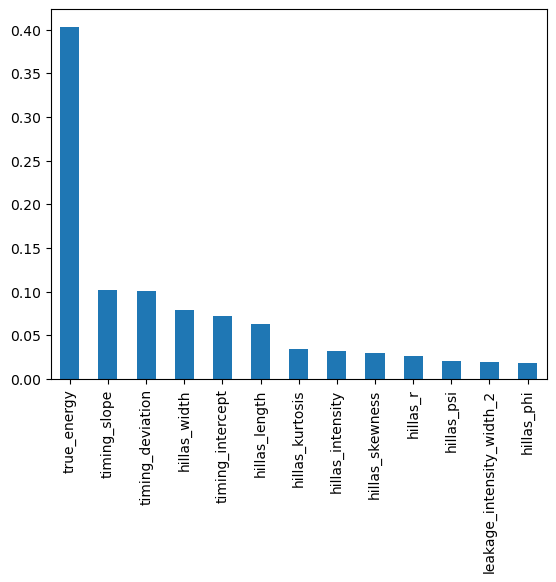

In [20]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Mostramos la importancia de cada parámetro
feature_importances.plot.bar();

Es sorprendente como el parámetro determinante realmente a la hora de tomar la decisión es el true_energy de lejos. Vamos a quitar de nuestro modelo los parámetros menos relevantes a la hora de tomar la decisión:

In [21]:
# Determinamos los parámetros (ahora vamos a escoger todos (menos los ID) para ver cuáles son los más relevantes y ver si el modelo mejora)
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 #'hillas_skewness',
 #'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 'timing_intercept',
 'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]
protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                             
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)]
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]

# Juntamos los dos dataframe
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             

label = []                                                                                             
for i in range(3409):
    label.append("proton")
for j in range(4119):
    label.append("gamma")
    
df_protongamma.insert(4,"label", label, True)

X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]   

# Ahora ya tenemos los datos procesados para podérselos dar al RF

Veamos las predicciones del RF con los nuevos parámetros:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf = RandomForestClassifier(n_estimators = 400, max_depth= 8)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Precisión: 82.51859723698193 %


### 2. Matriz de confusión

Estudiemos ahora la matriz de confusión y veamos cómo de bien predice si es un gamma o si es un protón:

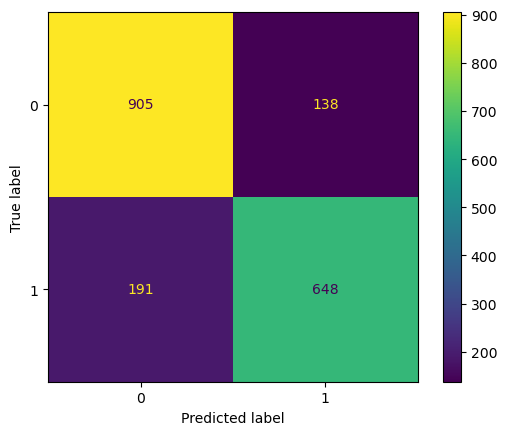

In [23]:
# Creamos la matriz de confusión para evaluar sus resultados
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

El modelo sigue teniendo problemas con protones y gammas pero ahora la confusión es mucho menor (precisión para gammas y protones es del 85 % y 80% respectivamente).

### 3. Refinando el modelo: hiperparámetros

Vamos a refinar los dos principales hiperparámetros del RF: el número de árboles y la profundidad de los mismos.

Para ello vamos a calcular la precisión de los resultados (una sola vez por lo que tendrán bastante dispersión los resultados) para varios valores del número de árboles (entre 100 y 500 tomando valores de 20 en 20) y la profudidad de los árboles (entre 9 y 54 decisiones tomando valores de 3 en 3). Más adelante podremos juntar estos resultados y determinar

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

nest1 = []
maxdep1 = []
accur1 = []

n0_estimators = 100
for i in range(20):
    max0_depth = 9
    for j in range(15):
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        nest1.append(n0_estimators)
        maxdep1.append(max0_depth)
        accur1.append(accuracy)
        max0_depth = max0_depth + 3
        print(accuracy)
    n0_estimators = n0_estimators + 20
    print()

0.8273113708820404
0.8342189160467588
0.834750265674814
0.8304994686503719
0.8336875664187035
0.8379383634431455
0.8342189160467588
0.8336875664187035
0.834750265674814
0.8358129649309245
0.8405951115834219
0.8336875664187035
0.8368756641870351
0.8358129649309245
0.8395324123273114

0.832624867162593
0.8374070138150903
0.8368756641870351
0.832624867162593
0.8390010626992561
0.8368756641870351
0.8379383634431455
0.834750265674814
0.8374070138150903
0.8390010626992561
0.834750265674814
0.8358129649309245
0.8331562167906482
0.8331562167906482
0.8374070138150903

0.8267800212539851
0.8352816153028693
0.8368756641870351
0.8395324123273114
0.842720510095643
0.8331562167906482
0.8379383634431455
0.8379383634431455
0.8405951115834219
0.8390010626992561
0.834750265674814
0.8342189160467588
0.8374070138150903
0.8331562167906482
0.8390010626992561

0.8331562167906482
0.8368756641870351
0.8352816153028693
0.8363443145589798
0.8368756641870351
0.8368756641870351
0.8405951115834219
0.839001062699256

Una vez hemos obtenido estos resultados, podemos representarlos para poder observar donde está el máximo o hacia donde tiende dentro de nuestro espacio definido por el número de árboles y su profundidad.

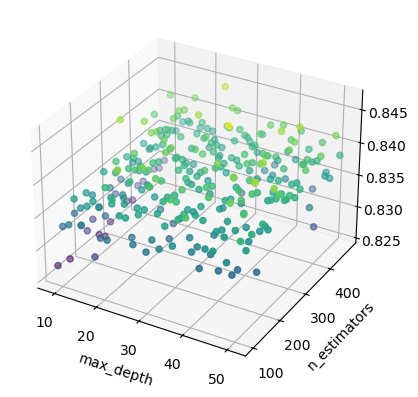

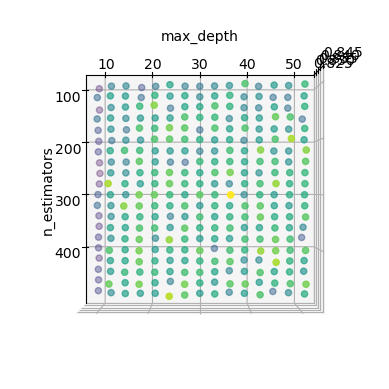

In [52]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d') 
ax.scatter(maxdep1, nest1, accur1, c=accur1, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest1, maxdep1, accur1, c=accur1, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

Vemos que el máximo se encuentra entre 30 y 50 (o incluso más) del número de decisiones y entre 100 y 450 (o incluso más) del número de árboles.

Ahora vamos a realizar el mismo cálculo pero estimando mejor los hiperparámetros y calculándolo unas 4 o 5 veces para calcular la media y tener una menor desviación de los resultados.

In [26]:
nest = []
maxdep = []
accur = []

n0_estimators = 100
for i in range(16):
    max0_depth = 18
    for j in range(15):
        # RF1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy1 = accuracy_score(y_test, y_pred)

        # RF2
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy2 = accuracy_score(y_test, y_pred)

        # RF3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy3 = accuracy_score(y_test, y_pred)

        # RF4
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy4 = accuracy_score(y_test, y_pred)

        accuracymean = (accuracy1 + accuracy2 + accuracy3 + accuracy4)/4
        
        nest.append(n0_estimators)
        maxdep.append(max0_depth)
        accur.append(accuracymean)
        
        max0_depth = max0_depth + 3
        print(accuracymean)
    n0_estimators = n0_estimators + 25
    print()

np.savetxt("n_estimators", nest)
np.savetxt("max_depth", maxdep)
np.savetxt("accuracy", accur)

0.8271785334750266
0.8261158342189161
0.8291710945802337
0.8283740701381509
0.8282412327311371
0.8306323060573857
0.8295696068012752
0.8358129649309245
0.8330233793836345
0.8363443145589797
0.8258501594048884
0.8289054197662062
0.8344845908607865
0.8291710945802337
0.8255844845908609

0.8261158342189161
0.8225292242295431
0.8290382571732199
0.8332890541976621
0.8278427205100957
0.8304994686503719
0.8247874601487779
0.827577045696068
0.8318278427205101
0.8262486716259299
0.8287725823591924
0.8279755579171094
0.8225292242295431
0.8308979808714133
0.82903825717322

0.8215993623804463
0.8198724760892667
0.8304994686503719
0.8314293304994687
0.8286397449521785
0.8222635494155153
0.8319606801275239
0.8308979808714133
0.8266471838469713
0.8254516471838469
0.8338204038257172
0.8323591923485654
0.82903825717322
0.8327577045696068
0.8285069075451648

0.825451647183847
0.82173219978746
0.834883103081828
0.8265143464399575
0.8246546227417642
0.8302337938363442
0.8356801275239107
0.8262486716259299

Representamos los resultados para llegar a alguna conclusión:

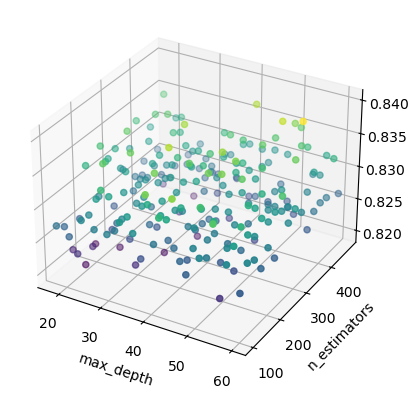

In [46]:
ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, accur, c=accur, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

Se estudia mejor desde ángulos concretos:

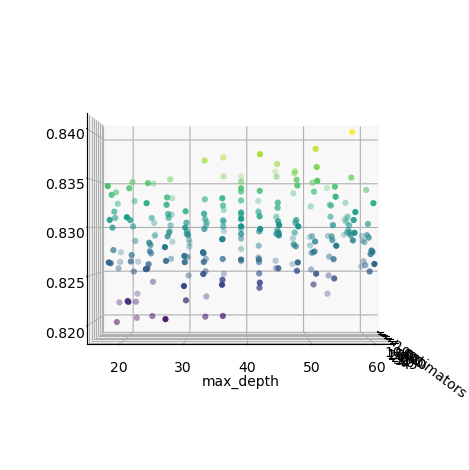

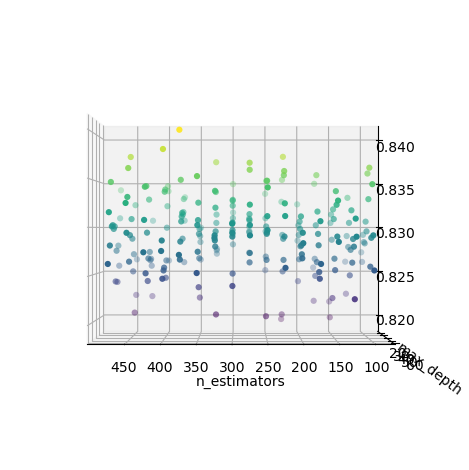

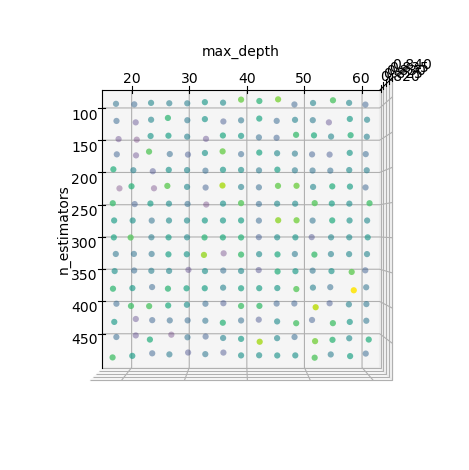

In [48]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, accur, c=accur, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

Parece que el valor óptimo de los hiperparámetros se encuentra a partir de una profundidad de 30 decisiones y un número de árboles superior a 250.

Volvemos a correr el programa reajustando estos hiperparámetros para intentar llegar al 85% de precisión en los resultados.

In [53]:
nestF = []
maxdepF = []
accurF = []

n0_estimators = 250
for i in range(16):
    max0_depth = 30
    for j in range(15):
        # RF1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy1 = accuracy_score(y_test, y_pred)

        # RF2
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy2 = accuracy_score(y_test, y_pred)

        # RF3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy3 = accuracy_score(y_test, y_pred)

        # RF4
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf = RandomForestClassifier(n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy4 = accuracy_score(y_test, y_pred)

        accuracymean = (accuracy1 + accuracy2 + accuracy3 + accuracy4)/4
        
        nestF.append(n0_estimators)
        maxdepF.append(max0_depth)
        accurF.append(accuracymean)
        
        max0_depth = max0_depth + 3
        print(accuracymean)
    n0_estimators = n0_estimators + 25
    print()

np.savetxt("n_estimatorsF", nestF)
np.savetxt("max_depthF", maxdepF)
np.savetxt("accuracyF", accurF)

0.8261158342189161
0.8249202975557917
0.833421891604676
0.8282412327311371
0.8301009564293305
0.8249202975557917
0.8297024442082891
0.8209351753453773
0.8312964930924548
0.8201381509032943
0.8293039319872477
0.8301009564293306
0.8286397449521785
0.8303666312433582
0.8304994686503719

0.8249202975557917
0.8263815090329436
0.8258501594048885
0.8234590860786398
0.8344845908607864
0.8269128586609988
0.8316950053134963
0.8281083953241233
0.835414452709883
0.8274442082890543
0.8286397449521785
0.8263815090329436
0.8254516471838471
0.8299681190223167
0.8306323060573858

0.8301009564293306
0.8332890541976621
0.8346174282678003
0.8286397449521785
0.8273113708820404
0.8301009564293306
0.8257173219978746
0.8318278427205101
0.8265143464399575
0.824654622741764
0.832624867162593
0.8320935175345378
0.8263815090329436
0.827577045696068
0.8261158342189161

0.8226620616365569
0.8356801275239107
0.8323591923485654
0.8247874601487779
0.8267800212539852
0.8306323060573858
0.8289054197662062
0.821732199787

Lo representamos para analizarlo:

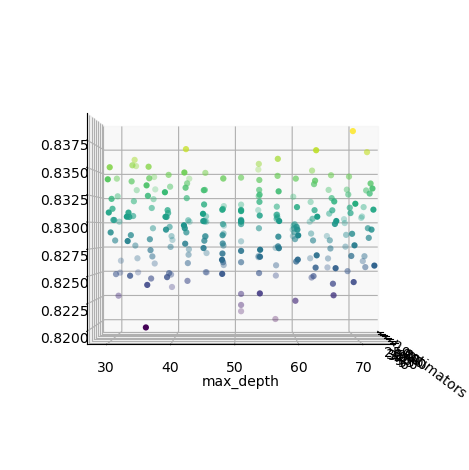

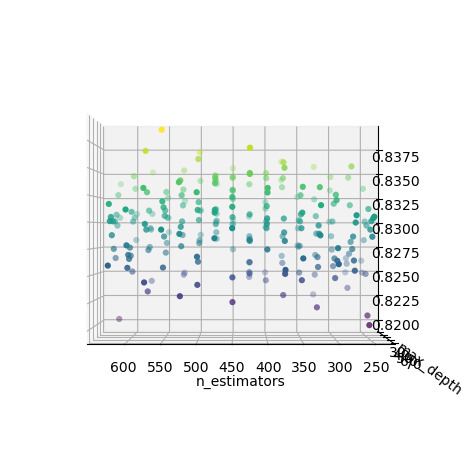

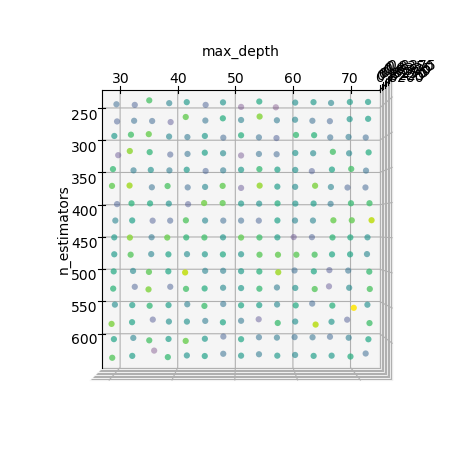

In [62]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(nestF, maxdepF, accurF, c=accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

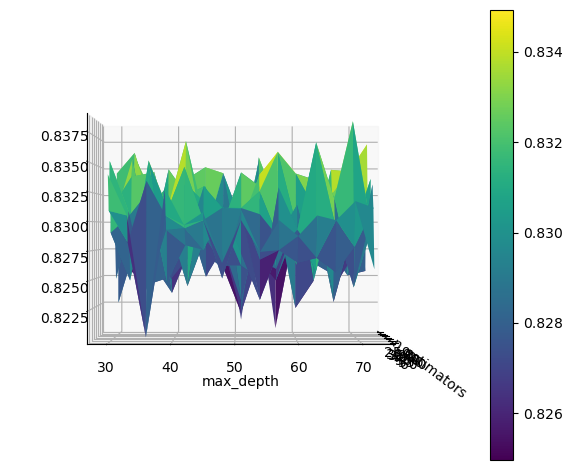

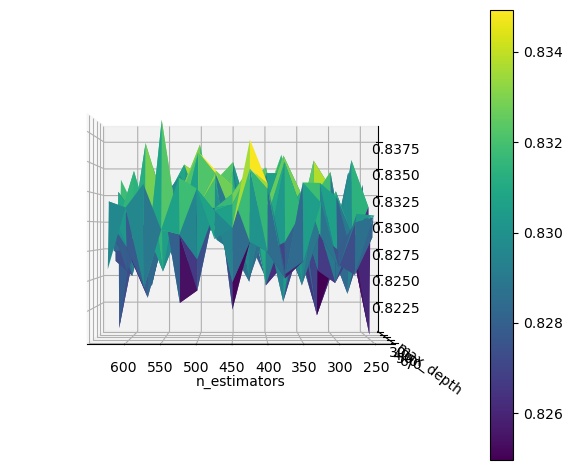

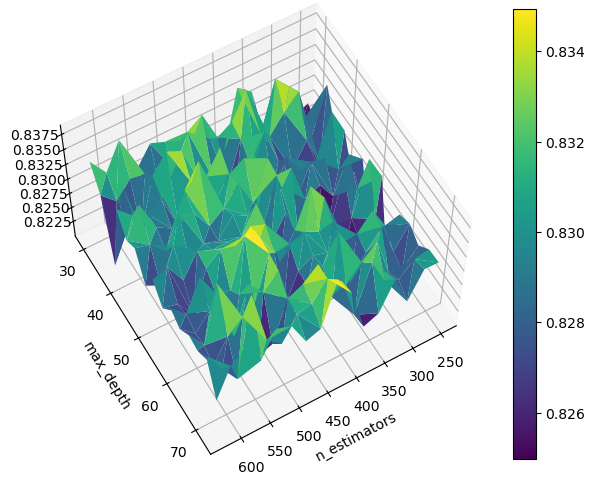

In [126]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nestF, maxdepF, accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nestF, maxdepF, accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nestF, maxdepF, accurF, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(60, 60)
plt.show()